# Scenario Generation

EMPIRE has six stochastic processes include PV, Wind_Offshore, Wind_Onshore, Seasonal_hydropower, Run_of_river, and Electricity_load. Also, Norway_TIMES has six stochastic processes consist of PV_type1, PV_type2, Wind, Seasonal_hydropower, Run_of_river, and Heat_demand.
We need to preserve three different correlation properties:
"1. Cross_correlation: Sampling the same hours for all stochastic processes.
"2. Temporal_autocorrelation: Sampling with respect to chronology.
"3. Spatial_correlation: Sampling the same hours in all regions.

TIMES and EMPIRE utilize the same data base (Ninja) to generate scenarios regarding PV and Wind, but data sources are not similar for Hydropower, Heat_demand, and Electricity_load. EMPIRE uses ENTSO-E which is the only reliable data source that provides Hydropower and Electricity_load from all European countries. On the other hand, Norway_TIMES is using the other data sources in order to get Norwegian Heat_demand and Hydropower. 
Norway_TIMES uses time series data from 2000 to 2015 to generate stochastic scenarios, while ENTSO-E can provide time series data from 2015 to 2019. Therefore, we cannot simply draw samples with the same hours from different data bases.
In this case, initialy TIMES generates three stochastic scenarios by using moment matching algorithm. The time series data, used for scenario generation, starts from 2000 and ends 2015. Although, we have preserved all correlation properties in stochastic scenarios for TIMES, we are not able to use the same hours data to generate stochastic scenarios of Hydropower and Electricity_load in EMPIRE. 
Generally we need to use wind and solar from generated stochastic scenarios (note: Both models use similar data base to generate wind and solar scenarios, so correlation properties are preserved in this case) to find the best samples for Hydro and Electricity_load between 2015 and 2019. Therefore, we need a method to find wind and solar samples (from 2015 to 2019) that have similar distribution to wind and solar from scenarios. Then, our assumption is that once we have wind and solar distribution similar to wind and solar from scenarios, we can have Hydro and Electricity_load from 2015 to 2019 that probably preserve cross_correlation.
There are different methods that can help us to compare samples such as moment matching and Wasserstein distance (W.D). We prefer to use W.D, because of evidences that shows it works better than moment matching and also it needs less computational effort.
In addition all samples should start from Monday, hour 00:00 to preserve temporal and spatial correlations.

In [1]:
import os
from csv import reader
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import random
import numpy as np
import pandas as pd
from random import seed
import matplotlib.pyplot as plt
from random import randint
import csv
from sklearn.cluster import KMeans
import re
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

Reading CSV files of stochastic scenarios provided by IFE.
period = \[1,2,3,4\] and season = \[autumn, spring, summer, winter\]

In [2]:
def periods(period,season):
    df_TIMES = pd.read_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) + '/PV_wind_hydro_temp_3scen_weekly_' + str(period) + '_' + season + '.csv', index_col=0, parse_dates=["DateTime"])
    return df_TIMES

Extracting DateTime: we need to access hours of corresponding scenarios to draw similar samples out of wind and solar time series data. 

In [3]:
def Date_TIMES(period,season):    
    DateTime_TIMES = periods(period,season)['DateTime']
    return DateTime_TIMES

In [4]:
##Reading time series data to generate scenarios for EMPIRE##
def df_EMPIRE(period,season):
    df_EMPIRE_solar = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\EMPIRE data\solar.csv', index_col=False, parse_dates=["time"])
    df_EMPIRE_windonshore = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\EMPIRE data\windonshore.csv', index_col=False, parse_dates=["time"])
    df_EMPIRE_windoffshore = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\EMPIRE data\windoffshore.csv', index_col=False, parse_dates=["time"])

    ## Extracting the same hours from EMPIRE data set##

    time_solar = []
    time_windonshore = []
    time_windoffshore = []

    for i in Date_TIMES(period,season):
        time_solar.append(df_EMPIRE_solar.loc[df_EMPIRE_solar['time']== i].values.tolist())

    for i in Date_TIMES(period,season):
        time_windonshore.append(df_EMPIRE_windonshore.loc[df_EMPIRE_windonshore['time']== i].values.tolist())

    for i in Date_TIMES(period,season):
        time_windoffshore.append(df_EMPIRE_windoffshore.loc[df_EMPIRE_windoffshore['time']== i].values.tolist())

    ### To get rid of list of list##
    flat_list_solar = [] 
    flat_list_windonshore = []
    flat_list_windoffshore = []   


    for i in time_solar:
        for n in i:
            flat_list_solar.append(n)

    for i in time_windonshore:
        for n in i:
            flat_list_windonshore.append(n)

    for i in time_windoffshore:
        for n in i:
            flat_list_windoffshore.append(n)


    ## Make a datafram of solar and wind with name for columns##


    col_solar = []
    col_windonshore = []
    col_windoffshore = []


    for col in df_EMPIRE_solar.columns:
        col_solar.append(col)
    
    for col in df_EMPIRE_windonshore.columns:
        col_windonshore.append(col)

    for col in df_EMPIRE_windoffshore.columns:
        col_windoffshore.append(col)
    
        
    Solar_EMPIRE = pd.DataFrame(flat_list_solar, columns = col_solar)    
    Windonshore_EMPIRE = pd.DataFrame(flat_list_windonshore, columns = col_windonshore)    
    Windoffshore_EMPIRE = pd.DataFrame(flat_list_windoffshore, columns = col_windoffshore)
    


    ### Seasonal classification, Autumn ##


    Solar_2015 = df_EMPIRE_solar.set_index(['time'])
    Wind_2015 = df_EMPIRE_windonshore.set_index(['time'])
    Wind_o_2015 = df_EMPIRE_windoffshore.set_index(['time'])



    d_s = Solar_2015.loc['2015-01-01 00:00:00' : ].astype(float)
    d_w_on = Wind_2015.loc['2015-01-01 00:00:00' : ].astype(float)
    d_w_off = Wind_o_2015.loc['2015-01-01 00:00:00' : ].astype(float)


    ### It should start from Monday ###
    if season == "autumn":
        fall_2015 = d_s.loc['2015-09-07 00:00:00':'2015-11-30 23:00:00']
        fall_2016 = d_s.loc['2016-09-05 00:00:00':'2016-11-30 23:00:00']
        fall_2017 = d_s.loc['2017-09-04 00:00:00':'2017-11-30 23:00:00']
        fall_2018 = d_s.loc['2018-09-03 00:00:00':'2018-11-30 23:00:00']
        fall_2019 = d_s.loc['2019-09-02 00:00:00':'2019-11-30 23:00:00']


        fall_w_2015 = d_w_on.loc['2015-09-07 00:00:00':'2015-11-30 23:00:00']
        fall_w_2016 = d_w_on.loc['2016-09-05 00:00:00':'2016-11-30 23:00:00']
        fall_w_2017 = d_w_on.loc['2017-09-04 00:00:00':'2017-11-30 23:00:00']
        fall_w_2018 = d_w_on.loc['2018-09-03 00:00:00':'2018-11-30 23:00:00']
        fall_w_2019 = d_w_on.loc['2019-09-02 00:00:00':'2019-11-30 23:00:00']


        fall_o_w_2015 = d_w_off.loc['2015-09-07 00:00:00':'2015-11-30 23:00:00']
        fall_o_w_2016 = d_w_off.loc['2016-09-05 00:00:00':'2016-11-30 23:00:00']
        fall_o_w_2017 = d_w_off.loc['2017-09-04 00:00:00':'2017-11-30 23:00:00']
        fall_o_w_2018 = d_w_off.loc['2018-09-03 00:00:00':'2018-11-30 23:00:00']
        fall_o_w_2019 = d_w_off.loc['2019-09-02 00:00:00':'2019-11-30 23:00:00']


    if season == "spring":
        fall_2015 = d_s.loc['2015-03-02 00:00:00':'2015-05-31 23:00:00']
        fall_2016 = d_s.loc['2016-03-07 00:00:00':'2016-05-31 23:00:00']
        fall_2017 = d_s.loc['2017-03-06 00:00:00':'2017-05-31 23:00:00']
        fall_2018 = d_s.loc['2018-03-05 00:00:00':'2018-05-31 23:00:00']
        fall_2019 = d_s.loc['2019-03-04 00:00:00':'2019-05-31 23:00:00']


        fall_w_2015 = d_w_on.loc['2015-03-02 00:00:00':'2015-05-31 23:00:00']
        fall_w_2016 = d_w_on.loc['2016-03-07 00:00:00':'2016-05-31 23:00:00']
        fall_w_2017 = d_w_on.loc['2017-03-06 00:00:00':'2017-05-31 23:00:00']
        fall_w_2018 = d_w_on.loc['2018-03-05 00:00:00':'2018-05-31 23:00:00']
        fall_w_2019 = d_w_on.loc['2019-03-04 00:00:00':'2019-05-31 23:00:00']


        fall_o_w_2015 = d_w_off.loc['2015-03-02 00:00:00':'2015-05-31 23:00:00']
        fall_o_w_2016 = d_w_off.loc['2016-03-07 00:00:00':'2016-05-31 23:00:00']
        fall_o_w_2017 = d_w_off.loc['2017-03-06 00:00:00':'2017-05-31 23:00:00']
        fall_o_w_2018 = d_w_off.loc['2018-03-05 00:00:00':'2018-05-31 23:00:00']
        fall_o_w_2019 = d_w_off.loc['2019-03-04 00:00:00':'2019-05-31 23:00:00']


    if season == "summer":
        fall_2015 = d_s.loc['2015-06-01 00:00:00':'2015-08-31 23:00:00']
        fall_2016 = d_s.loc['2016-06-06 00:00:00':'2016-08-31 23:00:00']
        fall_2017 = d_s.loc['2017-06-05 00:00:00':'2017-08-31 23:00:00']
        fall_2018 = d_s.loc['2018-06-04 00:00:00':'2018-08-31 23:00:00']
        fall_2019 = d_s.loc['2019-06-03 00:00:00':'2019-08-31 23:00:00']


        fall_w_2015 = d_w_on.loc['2015-06-01 00:00:00':'2015-08-31 23:00:00']
        fall_w_2016 = d_w_on.loc['2016-06-06 00:00:00':'2016-08-31 23:00:00']
        fall_w_2017 = d_w_on.loc['2017-06-05 00:00:00':'2017-08-31 23:00:00']
        fall_w_2018 = d_w_on.loc['2018-06-04 00:00:00':'2018-08-31 23:00:00']
        fall_w_2019 = d_w_on.loc['2019-06-03 00:00:00':'2019-08-31 23:00:00']


        fall_o_w_2015 = d_w_off.loc['2015-06-01 00:00:00':'2015-08-31 23:00:00']
        fall_o_w_2016 = d_w_off.loc['2016-06-06 00:00:00':'2016-08-31 23:00:00']
        fall_o_w_2017 = d_w_off.loc['2017-06-05 00:00:00':'2017-08-31 23:00:00']
        fall_o_w_2018 = d_w_off.loc['2018-06-04 00:00:00':'2018-08-31 23:00:00']
        fall_o_w_2019 = d_w_off.loc['2019-06-03 00:00:00':'2019-08-31 23:00:00']
        
        
    if season == "winter":
        fall_2015 = d_s.loc['2015-01-05 00:00:00':'2015-02-27 23:00:00']
        fall_2016 = d_s.loc['2015-12-07 00:00:00':'2016-02-29 23:00:00']
        fall_2017 = d_s.loc['2016-12-05 00:00:00':'2017-02-28 23:00:00']
        fall_2018 = d_s.loc['2017-12-04 00:00:00':'2018-02-28 23:00:00']
        fall_2019 = d_s.loc['2018-12-03 00:00:00':'2019-02-28 23:00:00']


        fall_w_2015 = d_w_on.loc['2015-01-05 00:00:00':'2015-02-27 23:00:00']
        fall_w_2016 = d_w_on.loc['2015-12-07 00:00:00':'2016-02-29 23:00:00']
        fall_w_2017 = d_w_on.loc['2016-12-05 00:00:00':'2017-02-28 23:00:00']
        fall_w_2018 = d_w_on.loc['2017-12-04 00:00:00':'2018-02-28 23:00:00']
        fall_w_2019 = d_w_on.loc['2018-12-03 00:00:00':'2019-02-28 23:00:00']


        fall_o_w_2015 = d_w_off.loc['2015-01-05 00:00:00':'2015-02-27 23:00:00']
        fall_o_w_2016 = d_w_off.loc['2015-12-07 00:00:00':'2016-02-29 23:00:00']
        fall_o_w_2017 = d_w_off.loc['2016-12-05 00:00:00':'2017-02-28 23:00:00']
        fall_o_w_2018 = d_w_off.loc['2017-12-04 00:00:00':'2018-02-28 23:00:00']
        fall_o_w_2019 = d_w_off.loc['2018-12-03 00:00:00':'2019-02-28 23:00:00']


        #### samples 2015-2019###
    
    sea = ["fall_", "fall_w_", "fall_o_w_"]
    year = ['2015','2016', '2017','2018', '2019']
    sa = {"fall_":'samples_', "fall_w_":'samples_w_', "fall_o_w_":'samples_o_w_'}
    
    samples_2015 = []
    samples_2016 = []
    samples_2017 = []
    samples_2018 = []
    samples_2019 = []
    
    samples_w_2015 = []
    samples_w_2016 = []
    samples_w_2017 = []
    samples_w_2018 = []
    samples_w_2019 = []
    
    samples_o_w_2015 = []
    samples_o_w_2016 = []
    samples_o_w_2017 = []
    samples_o_w_2018 = []
    samples_o_w_2019 = []
    
    
    
    for i in sea:
        for ite in year:
            nam = i + ite
        
            for s in range(len(eval(nam))):
                if s == 0:    
                    end = s + 168
                    samples = eval(nam).iloc[s:end]
                    if len(samples) == 168:
                        for key, value in sa.items():
                            if key == i:
                                new = sa.get(key) + ite
                                eval(new).append(samples)
                            else:
                                pass

                elif s > 0:
                    ss = 168*s
                    end = ss + 168
                    samples = eval(nam).iloc[ss:end]
                    if len(samples) == 168:
                        for key, value in sa.items():
                            if key == i:
                                new = sa.get(key) + ite
                                eval(new).append(samples)
                            else:
                                pass



    for i in samples_2016:
        samples_2015.append(i)
    
    for i in samples_2017:
        samples_2015.append(i)
       
    for i in samples_2018:
        samples_2015.append(i)
    
    for i in samples_2019:
        samples_2015.append(i)
    
    samples_solar_2015_2019 = samples_2015



    for i in samples_w_2016:
        samples_w_2015.append(i)
    
    for i in samples_w_2017:
        samples_w_2015.append(i)
       
    for i in samples_w_2018:
        samples_w_2015.append(i)
    
    for i in samples_w_2019:
        samples_w_2015.append(i)
    
    samples_windonshore_2015_2019 = samples_w_2015



    for i in samples_o_w_2016:
        samples_o_w_2015.append(i)
    
    for i in samples_o_w_2017:
        samples_o_w_2015.append(i)
       
    for i in samples_o_w_2018:
        samples_o_w_2015.append(i)
    
    for i in samples_o_w_2019:
        samples_o_w_2015.append(i)
    
    samples_windoffshore_2015_2019 = samples_o_w_2015



    ################### Solar scenarios regarding EMPIRE data #####################

    Solar_sce1_NO= Solar_EMPIRE[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].iloc[0:168]
    Solar_sce1_NO['avg_NO'] = Solar_sce1_NO[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].mean(axis=1)

    Solar_sce2_NO= Solar_EMPIRE[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].iloc[168:336]
    Solar_sce2_NO['avg_NO'] = Solar_sce2_NO[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].mean(axis=1)

    Solar_sce3_NO= Solar_EMPIRE[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].iloc[336:504]
    Solar_sce3_NO['avg_NO'] = Solar_sce3_NO[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].mean(axis=1)



    ################### Wind off shore scenarios regarding EMPIRE data #####################

    Windoffshore_sce1_NO= Windoffshore_EMPIRE['NO'].iloc[0:168]

    Windoffshore_sce2_NO= Windoffshore_EMPIRE['NO'].iloc[168:336]

    Windoffshore_sce3_NO= Windoffshore_EMPIRE['NO'].iloc[336:504]


    ################### Wasserstein dist. #####################


    df_EMPIRE_hydroror = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\EMPIRE data\hydroror.csv', index_col=False, parse_dates=["time"])
    df_EMPIRE_hydroseasonal = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\EMPIRE data\hydroseasonal.csv', index_col=False, parse_dates=["time"])
    df_EMPIRE_electricload = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\EMPIRE data\electricload.csv', index_col=False, parse_dates=["time"])




    ws_windoffshore_sce1 = []
    ws_windoffshore_sce2 = []
    ws_windoffshore_sce3 = []
    
    ws_solar_sce1 = []
    ws_solar_sce2 = []
    ws_solar_sce3 = []





    for i in samples_windoffshore_2015_2019:
        wasser = wasserstein_distance(i['NO'], Windoffshore_sce1_NO )
        ws_windoffshore_sce1.append(wasser)
        
    for i in samples_windoffshore_2015_2019:
        wasser = wasserstein_distance(i['NO'], Windoffshore_sce2_NO )
        ws_windoffshore_sce2.append(wasser)
    
    for i in samples_windoffshore_2015_2019:
        wasser = wasserstein_distance(i['NO'], Windoffshore_sce3_NO )
        ws_windoffshore_sce3.append(wasser)




    for i in samples_solar_2015_2019:
        i['avg_NO'] = i[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].mean(axis=1)
        wasser = wasserstein_distance(i['avg_NO'], Solar_sce1_NO['avg_NO'])
        ws_solar_sce1.append(wasser)

    for i in samples_solar_2015_2019:
        i['avg_NO'] = i[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].mean(axis=1)
        wasser = wasserstein_distance(i['avg_NO'], Solar_sce2_NO['avg_NO'])
        ws_solar_sce2.append(wasser)
    
    for i in samples_solar_2015_2019:
        i['avg_NO'] = i[['NO1', 'NO2', 'NO3', 'NO4', 'NO5']].mean(axis=1)
        wasser = wasserstein_distance(i['avg_NO'], Solar_sce3_NO['avg_NO'])
        ws_solar_sce3.append(wasser)
    





    

    ws_wind_solar_sce1 = pd.DataFrame({'wind':ws_windoffshore_sce1, 'solar':ws_solar_sce1 })
    ws_wind_solar_sce1['avg'] = ws_wind_solar_sce1[['wind','solar']].mean(axis=1)
    
    ws_wind_solar_sce2 = pd.DataFrame({'wind':ws_windoffshore_sce2, 'solar':ws_solar_sce2 })
    ws_wind_solar_sce2['avg'] = ws_wind_solar_sce2[['wind','solar']].mean(axis=1)

    ws_wind_solar_sce3 = pd.DataFrame({'wind':ws_windoffshore_sce3, 'solar':ws_solar_sce3 })
    ws_wind_solar_sce3['avg'] = ws_wind_solar_sce3[['wind','solar']].mean(axis=1)




    selected_sample_sce1 = samples_solar_2015_2019[ws_wind_solar_sce1['avg'].idxmin()]
    sample_indices_sce1= selected_sample_sce1.index

    selected_sample_sce2 = samples_solar_2015_2019[ws_wind_solar_sce2['avg'].idxmin()]
    sample_indices_sce2= selected_sample_sce2.index

    selected_sample_sce3 = samples_solar_2015_2019[ws_wind_solar_sce3['avg'].idxmin()]
    sample_indices_sce3= selected_sample_sce3.index




    sample_hydroror_sce1_fall = []
    sample_hydroseasonal_sce1_fall = []
    sample_electricload_sce1_fall = []

    sample_hydroror_sce2_fall = []
    sample_hydroseasonal_sce2_fall = []
    sample_electricload_sce2_fall = []

    sample_hydroror_sce3_fall = []
    sample_hydroseasonal_sce3_fall = []
    sample_electricload_sce3_fall = []




    for i in sample_indices_sce1:
        sample_hydroror_sce1_fall.append(df_EMPIRE_hydroror.loc[df_EMPIRE_hydroror['time']==i])
        sample_hydroseasonal_sce1_fall.append(df_EMPIRE_hydroseasonal.loc[df_EMPIRE_hydroseasonal['time']==i])
        sample_electricload_sce1_fall.append(df_EMPIRE_electricload.loc[df_EMPIRE_electricload['time']==i])

    for i in sample_indices_sce2:
        sample_hydroror_sce2_fall.append(df_EMPIRE_hydroror.loc[df_EMPIRE_hydroror['time']==i])
        sample_hydroseasonal_sce2_fall.append(df_EMPIRE_hydroseasonal.loc[df_EMPIRE_hydroseasonal['time']==i])
        sample_electricload_sce2_fall.append(df_EMPIRE_electricload.loc[df_EMPIRE_electricload['time']==i])
    
    for i in sample_indices_sce3:
        sample_hydroror_sce3_fall.append(df_EMPIRE_hydroror.loc[df_EMPIRE_hydroror['time']==i])
        sample_hydroseasonal_sce3_fall.append(df_EMPIRE_hydroseasonal.loc[df_EMPIRE_hydroseasonal['time']==i])
        sample_electricload_sce3_fall.append(df_EMPIRE_electricload.loc[df_EMPIRE_electricload['time']==i])





    final_sample_hydroror_sce1_fall = pd.concat(sample_hydroror_sce1_fall)
    final_sample_hydroseasonal_sce1_fall = pd.concat(sample_hydroseasonal_sce1_fall)
    final_sample_electricload_sce1_fall = pd.concat(sample_electricload_sce1_fall)

    final_sample_hydroror_sce2_fall = pd.concat(sample_hydroror_sce2_fall)
    final_sample_hydroseasonal_sce2_fall = pd.concat(sample_hydroseasonal_sce2_fall)
    final_sample_electricload_sce2_fall = pd.concat(sample_electricload_sce2_fall)

    final_sample_hydroror_sce3_fall = pd.concat(sample_hydroror_sce3_fall)
    final_sample_hydroseasonal_sce3_fall = pd.concat(sample_hydroseasonal_sce3_fall)
    final_sample_electricload_sce3_fall = pd.concat(sample_electricload_sce3_fall)




    Hydroror_EMPIRE = pd.concat([final_sample_hydroror_sce1_fall,final_sample_hydroror_sce2_fall,final_sample_hydroror_sce3_fall]) 
    Hydroseasonal_EMPIRE = pd.concat([final_sample_hydroseasonal_sce1_fall,final_sample_hydroseasonal_sce2_fall,final_sample_hydroseasonal_sce3_fall]) 
    Electricload_EMPIRE = pd.concat([final_sample_electricload_sce1_fall,final_sample_electricload_sce2_fall,final_sample_electricload_sce3_fall])

################ CSV file ######################

    Solar_EMPIRE.to_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) + '/solar_EMPIRE_3scen_weekly_' + str(period) + '_' + season + '.csv', index = False)
    Windonshore_EMPIRE.to_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) +'/Windonshore_EMPIRE_3scen_weekly_' + str(period) + '_' + season + '.csv', index = False)
    Windoffshore_EMPIRE.to_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) +'/Windoffshore_EMPIRE_3scen_weekly_' + str(period) + '_' + season + '.csv', index = False)

    Hydroror_EMPIRE.to_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) +'/Hydroror_EMPIRE_3scen_weekly_' + str(period) + '_' + season +'.csv', index = False)
    Hydroseasonal_EMPIRE.to_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) +'/Hydroseasonal_EMPIRE_3scen_weekly_' + str(period) + '_' + season +'.csv', index = False)
    Electricload_EMPIRE.to_csv(r'C:/Users/mohaa/Desktop/Sto. Sce/period ' + str(period) +'/Electricload_EMPIRE_3scen_weekly_' + str(period) + '_' + season +'.csv', index = False)
    
    
    return Solar_EMPIRE, Windonshore_EMPIRE, Windoffshore_EMPIRE, Hydroror_EMPIRE, Hydroseasonal_EMPIRE, Electricload_EMPIRE  


In [5]:
total_period = [1,2,3,4]
total_seasons = ['autumn', 'spring', 'summer', 'winter']

In [6]:
for tp in total_period:
    for ts in total_seasons:
        df_EMPIRE(tp,ts)

C:\Users\mohaa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mohaa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mohaa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [7]:
Solar_EMPIRE = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\solar_EMPIRE_3scen_weekly_1_spring.csv')
Solar_EMPIRE = Solar_EMPIRE.loc[0:167,['time', 'NO1']]

Electricload_EMPIRE = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\Electricload_EMPIRE_3scen_weekly_1_spring.csv')
Electricload_EMPIRE = Electricload_EMPIRE.loc[0:167,'NO1']

Hydroror_EMPIRE = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\Hydroror_EMPIRE_3scen_weekly_1_spring.csv')
Hydroror_EMPIRE = Hydroror_EMPIRE.loc[0:167,'NO1']

Hydroseasonal_EMPIRE = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\Hydroseasonal_EMPIRE_3scen_weekly_1_spring.csv')
Hydroseasonal_EMPIRE = Hydroseasonal_EMPIRE.loc[0:167,'NO1']

Windoffshore_EMPIRE = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\Windoffshore_EMPIRE_3scen_weekly_1_spring.csv')
Windoffshore_EMPIRE = Windoffshore_EMPIRE.loc[0:167,'NO']

Windonshore_EMPIRE = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\Windonshore_EMPIRE_3scen_weekly_1_spring.csv')
Windonshore_EMPIRE = Windonshore_EMPIRE.loc[0:167,'NO1']

#### TIMES_Spring_Period1 ###
Data_TIMES = pd.read_csv(r'C:\Users\mohaa\Desktop\Sto. Sce\period 1\PV_wind_hydro_temp_3scen_weekly_1_spring.csv')
Solar_TIMES = Data_TIMES.loc[0:167,['ELC-PV-RES_NO1', 'DateTime']]
Wind_TIMES = Data_TIMES.loc[0:167,'ELC-WIND_NO1']
HydroRegulated_TIMES = Data_TIMES.loc[0:167,'ELC-HYD-REG_NO1']
HydroRun_TIMES = Data_TIMES.loc[0:167,'ELC-RUN_NO1']
Norm_Temperature_TIMES = Data_TIMES.loc[0:167,'Norm TEMPERATURE_NO1']

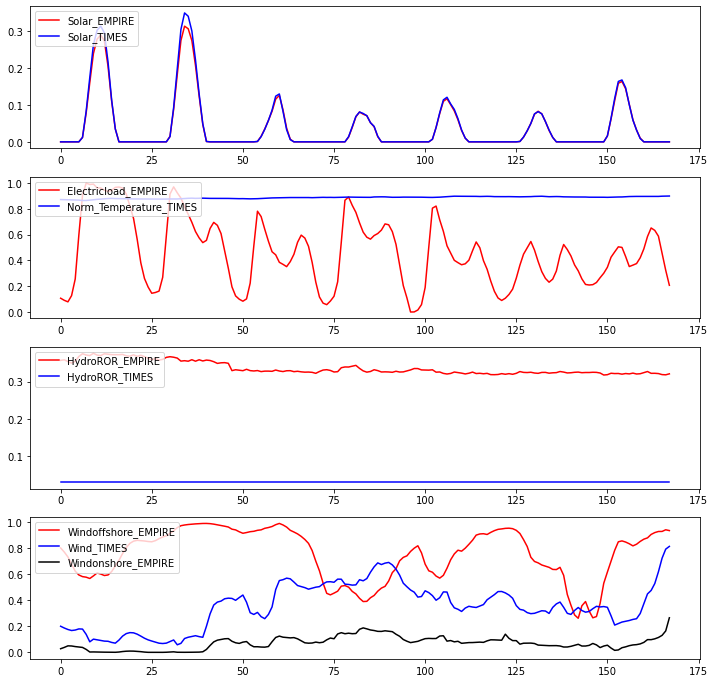

In [8]:
l = pd.Series(list(range(0,168)))
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(4,1,1)
colors = ['red', 'blue']
hor = l
ver = Solar_EMPIRE['NO1']
label = 'Solar_EMPIRE'
ax1.plot(hor, ver, c=colors[0], label=label)
hor1 = l
ver1 = Solar_TIMES['ELC-PV-RES_NO1']
label1 = 'Solar_TIMES'
ax1.plot(hor1, ver1, c=colors[1], label=label1)
ax1.legend(loc='upper left')
# ax1.title("Solar_Ava_sce1_TIMES VS EMPIRE_Spring")
# plt.xlabel("Hour, Integer")
# plt.ylabel("Availability factor, Percent")

ax2 = fig.add_subplot(4,1,2)
colors = ['red', 'blue']
hor = l
ver = Electricload_EMPIRE
ver.to_numpy()
maxx = np.max(ver)
minn = np.min(ver)
ver_scaled = np.array([(x - minn) / (maxx - minn) for x in ver])
label = 'Electricload_EMPIRE'
ax2.plot(hor, ver_scaled, c=colors[0], label=label)
hor1 = l
ver1 = Norm_Temperature_TIMES
label1 = 'Norm_Temperature_TIMES'
ax2.plot(hor1, ver1, c=colors[1], label=label1)
ax2.legend(loc='upper left')
# ax2.title("Norm_Temperature VS Electricload_Ava_sce1_Spring")
# ax2.xlabel("Hour, Integer")
# ax2.ylabel("Availability factor, Percent")


ax3 = fig.add_subplot(4,1,3)
colors = ['red', 'blue']
hor = l
ver = Hydroror_EMPIRE

label = 'HydroROR_EMPIRE'
ax3.plot(hor, ver, c=colors[0], label=label)
hor1 = l
ver1 = HydroRun_TIMES
label1 = 'HydroROR_TIMES'
ax3.plot(hor1, ver1, c=colors[1], label=label1)
ax3.legend(loc='upper left')


ax4 = fig.add_subplot(4,1,4)
colors = ['red', 'blue' , 'black']
hor = l
ver = Windoffshore_EMPIRE
label = 'Windoffshore_EMPIRE'
ax4.plot(hor, ver, c=colors[0], label=label)
hor1 = l
ver1 = Wind_TIMES
label1 = 'Wind_TIMES'
ax4.plot(hor1, ver1, c=colors[1], label=label1)
hor2 = l
ver2 = Windonshore_EMPIRE
label2 = 'Windonshore_EMPIRE'
ax4.plot(hor2, ver2, c=colors[2], label=label2)
ax4.legend(loc='upper left')


plt.show()
